In [1]:
! pip install qiskit -q

     |████████████████████████████████| 6.1 MB 4.7 MB/s 
     |████████████████████████████████| 17.9 MB 437 kB/s 
     |████████████████████████████████| 237 kB 49.9 MB/s 
     |████████████████████████████████| 207 kB 49.3 MB/s 
     |████████████████████████████████| 2.1 MB 35.4 MB/s 
     |████████████████████████████████| 634 kB 51.5 MB/s 
     |████████████████████████████████| 1.4 MB 53.0 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 943 kB 54.6 MB/s 
     |████████████████████████████████| 38.2 MB 76.3 MB/s 
     |████████████████████████████████| 3.6 MB 51.4 MB/s 
     |████████████████████████████████| 6.3 MB 28.0 MB/s 


In [5]:
!pip install opencv-python

     |████████████████████████████████| 60.3 MB 1.1 MB/s eta 0:00:01     |██████▎                         | 11.9 MB 3.9 MB/s eta 0:00:13     |███████████████▏                | 28.5 MB 4.8 MB/s eta 0:00:07


In [20]:
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import noise

import skimage.color
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import math
from skimage.transform import resize
from sklearn.svm import SVC
import cv2
import time

In [21]:
#@title ImageUtils code preprocessing, spliting, merging
class ImageUtils(object):
  #1. resize to 8 pixels
  #2. convert RGB to gray scale
  #3. apply OTSU threshold to enhance image
  #4. convert image to floating point
  @staticmethod
  def preProcess(image,verbose=False):
    image = resize(image, (32,32),anti_aliasing=True)
    if verbose:
      print(image.shape)

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    bg=cv2.morphologyEx(image, cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_RECT , (8,8)))
    out_gray=cv2.divide(image, bg, scale=255)
    out_gray = out_gray.astype(np.uint8)
    image=cv2.threshold(out_gray, 0, 255, cv2.THRESH_OTSU )[1]
    if image.max() > 1.0:
      image = image[:,:]/255
    return image
  
  #split image in N image_crop_size blocks
  @staticmethod
  def split_image(image,image_crop_size):
    (imageWidth, imageHeight)=image.shape
    gridx = gridy = image_crop_size
    image_splits = []
    for h in range(0,imageHeight,gridy):
        for w in range(0,imageWidth,gridx):
            slice_bit = image[h:h+gridy, w:w+gridx]
            if slice_bit.max() > 1.0:
              slice_bit = slice_bit / 255
            image_splits.append(slice_bit)
    # print(len(image_splits), len(image_splits[0]),len(image_splits[-1]))
    assert len(image_splits) != len(image_splits[0]) and len(image_splits[-1])
    return image_splits

  #Helper function for concat_tile
  @staticmethod
  def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation) for im in im_list]
    return cv2.hconcat(im_list_resize)
  #Helper function for concat_tile
  @staticmethod
  def vconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
      w_min = min(im.shape[1] for im in im_list)
      im_list_resize = [cv2.resize(im, (w_min, int(im.shape[0] * w_min / im.shape[1])), interpolation=interpolation) for im in im_list]
      return cv2.vconcat(im_list_resize)
  # Helper function for mergeAndDisplay : 2d Grid of Images, output: merged image
  @staticmethod
  def concat_tile_resize(im_list_2d, interpolation=cv2.INTER_CUBIC):
      im_list_v = [ImageUtils.hconcat_resize_min(im_list_h, interpolation=cv2.INTER_CUBIC) for im_list_h in im_list_2d]
      return ImageUtils.vconcat_resize_min(im_list_v, interpolation=cv2.INTER_CUBIC)
  
  # input: 1D list of image splits, number of patches in one row
  @staticmethod
  def mergeAndDisplay(image_splits, patch_per_line,verbose=False):
    img_list = []
    cur = []
    for i,img in enumerate(image_splits):
      if i!=0 and i % patch_per_line == 0:
        img_list.append(cur)
        cur = []
      cur.append(img)
    img_list.append(cur)
    im_tile_resize = ImageUtils.concat_tile_resize(img_list)
    if verbose:
      plt.imshow(im_tile_resize)
      plt.show()
    return im_tile_resize

In [42]:
noise_model = NoiseModel()
noise_model.basis_gates

['cx', 'id', 'rz', 'sx']

In [110]:
#@title QuantumProcessor code:- simulator circuit todo: real quantum machine
class QuantumProcessor(object):
  def __init__(self,image_crop_size):
    # Initialize some global variable for number of qubits
    self.image_crop_size = image_crop_size
    self.data_qb = math.ceil(math.log2(image_crop_size**2))
    anc_qb = 1
    self.total_qb = self.data_qb + anc_qb
    print('total qbits ' ,self.total_qb)
    # Initialize the amplitude permutation unitary
    self.D2n_1 = np.roll(np.identity(2**self.total_qb), 1, axis=1)

  # Convert the raw pixel values to probability amplitudes
  def amplitude_encode(self,img_data):
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    image_norm = []
    for arr in img_data:
      for ele in arr:
        image_norm.append(ele / rms)      
    return np.array(image_norm)


  def get_noise_model(self):
    noise_model = NoiseModel()
    # Error probabilities
    prob_1 = 0.5  # 1-qubit gate
    prob_2 = 0.5   # 2-qubit gate

    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(prob_1, 1)
    error_2 = noise.depolarizing_error(prob_2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'h', 'id', 'rz', 'sx', 'rx', 'ry'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    
    return noise_model

  # runing the ciruit on simulator
  def runOnSimulator(self,back, circuit, qc_h, qc_v):
    noise_model = self.get_noise_model()
    results = execute(circuit, backend=back, noise_model=noise_model).result()
    sv_h = results.get_statevector(qc_h)
    sv_v = results.get_statevector(qc_v)
    return sv_h,sv_v

  def getImgCropSize(self):
    return self.image_crop_size

  # input: 1D splited images, output: edge detected 1D splitted images
  def simulatorCircuit(self,image_splits,verbose=False):
    threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)
    back = Aer.get_backend('statevector_simulator')
    qc_h = QuantumCircuit(self.total_qb)
    qc_v = QuantumCircuit(self.total_qb)

    edges = []
    tot_time = time.time()
    for i in range(len(image_splits)):
        start_time = time.time() 
        img = image_splits[i]
        if img.sum() == 0:
          edges.append(img.astype(int))
          continue

        #encoding
        image_norm_h = self.amplitude_encode(img)
        if verbose:
          print("h", image_norm_h.sum())
        image_norm_v = self.amplitude_encode(img.T)
        if verbose:
          print("v", image_norm_v.sum())
      
        # horizontal
        qc_h.initialize(image_norm_h, range(1, self.total_qb))
        qc_h.h(0)
        qc_h.unitary(self.D2n_1, range(self.total_qb))
        qc_h.h(0)
        
        # vertical    
        qc_v.initialize(image_norm_v, range(1, self.total_qb))
        qc_v.h(0)
        qc_v.unitary(self.D2n_1, range(self.total_qb))
        qc_v.h(0)

        circ_list = [qc_h, qc_v]
        
        #running the ciruit 
        sv_h, sv_v = self.runOnSimulator(back, circ_list, qc_h, qc_v)

        edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**self.data_qb)])).reshape(self.image_crop_size, self.image_crop_size)
        edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**self.data_qb)])).reshape(self.image_crop_size, self.image_crop_size).T
        edge_scan_sim = edge_scan_h | edge_scan_v
        if verbose:
          plt.imshow(edge_scan_sim)
          plt.show()
          print(edge_scan_sim.shape)
        edges.append(edge_scan_sim)
        if verbose:
          print(i,":->",time.time() - start_time)
        # plot_image(edge_scan_sim, 'Edge Detected image')
    if verbose:
      print('total time',time.time() -  tot_time)
    return edges

  def quantumEdgeDetect(self,img,qProcessor,verbose = False):
    if verbose:
      plt.imshow(img)
      plt.show()
    img = ImageUtils.preProcess(img,verbose)
    if verbose:
      plt.imshow(img)
      plt.show()
    img_grid = ImageUtils.split_image(img,qProcessor.getImgCropSize())

    edges = qProcessor.simulatorCircuit(img_grid,verbose)
    merged_img = ImageUtils.mergeAndDisplay(edges,img.shape[0]/qProcessor.getImgCropSize(),verbose)
    
    return merged_img


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


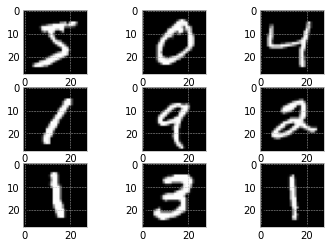

In [111]:
#load dataset
from tensorflow.keras.datasets import mnist
(trainX, trainy), (testX, testy) = mnist.load_data()
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
plt.show()

In [114]:
#config
image_crop_size =4
qProcessor = QuantumProcessor(image_crop_size)

#testing on 1 image
merged_img = qProcessor.quantumEdgeDetect(trainX[23],qProcessor)

total qbits  5


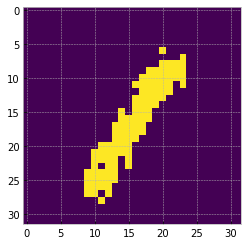

In [115]:
plt.imshow(merged_img)
plt.show()

In [89]:
### Test data from Noiseless Model
# testNsample = 50
# newTestX = np.zeros((testNsample, 32*32))
# for i in range(testNsample):
#   newTestX[i] = qProcessor.quantumEdgeDetect(testX[i],qProcessor).flatten()
#   if i%10==0:
#     print('status :',i,'/',testNsample)

In [90]:
# 32 x 32 because MNIST is resized to 32 pixels
start_time = time.time()
trainNsample = 100
newTrainX = np.zeros((trainNsample, 32*32))
for i in range(trainNsample):
  newTrainX[i] = qProcessor.quantumEdgeDetect(trainX[i],qProcessor).flatten()
  if i%10==0:
    print('status :',i,'/',trainNsample)
# testNsample = 50
# newTestX = np.zeros((testNsample, 32*32))
# for i in range(testNsample):
#   newTestX[i] = qProcessor.quantumEdgeDetect(testX[i],qProcessor).flatten()
#   if i%10==0:
#     print('status :',i,'/',testNsample)
print("Time taken: ", time.time() - start_time)

status : 0 / 100
status : 10 / 100
status : 20 / 100
status : 30 / 100
status : 40 / 100
status : 50 / 100
status : 60 / 100
status : 70 / 100
status : 80 / 100
status : 90 / 100
Time taken:  867.7758731842041


In [91]:
from sklearn.linear_model import LogisticRegression
clf2 = LogisticRegression(fit_intercept=True,
                        multi_class='auto',
                        penalty='l1', #lasso regression
                        solver='saga',
                        max_iter=1000,
                        C=50,
                        verbose=2, # output progress
                        n_jobs=5, # parallelize over 5 processes
                        tol=0.01
                         )

clf2 = clf2.fit(newTrainX, trainy[:trainNsample])

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 29 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.5s finished


In [92]:
clf2 = clf2.fit(newTrainX, trainy[:trainNsample])
print("Accuracy on test dataset = %3.2f" %(clf2.score(newTestX, testy[:testNsample])))

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 28 epochs took 1 seconds
Accuracy on test dataset = 0.78


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.5s finished


In [93]:
# Noise 0: 0.78
# Noise 0.001: 0.74
# Noise 0.01: 0.80
# Noise 0.1: 0.76
# Noise 0.5: 0.76

### Noise

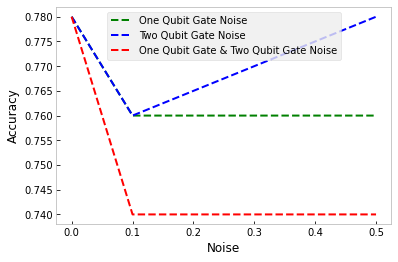

In [148]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.set_facecolor("white")
ax.grid(False)
single_gate = [0.78, 0.76, 0.76]
y = [0, 0.1, 0.5]
plt.plot(y, single_gate, 'g--', label='One Qubit Gate Noise')

two_qubit_gate = [0.78, 0.76, 0.78]
plt.plot(y, two_qubit_gate, 'b--', label='Two Qubit Gate Noise')

combined_gates = [0.78, 0.74, 0.74]
plt.plot(y, combined_gates,  'r--', label='One Qubit Gate & Two Qubit Gate Noise',)
plt.xlabel('Noise')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)


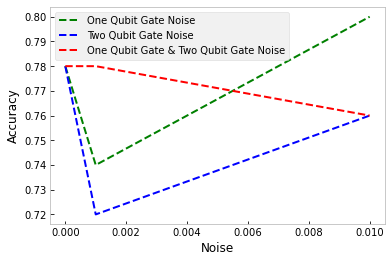

In [147]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.set_facecolor("white")
ax.grid(False)
single_gate = [0.78, 0.74, 0.80]
y = [0, 0.001, 0.01]
plt.plot(y, single_gate, 'g--', label='One Qubit Gate Noise')

two_qubit_gate = [0.78, 0.72, 0.76]
plt.plot(y, two_qubit_gate, 'b--', label='Two Qubit Gate Noise')

combined_gates = [0.78, 0.78, 0.76]
plt.plot(y, combined_gates,  'r--', label='One Qubit Gate & Two Qubit Gate Noise',)
plt.xlabel('Noise')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)


# Visualization

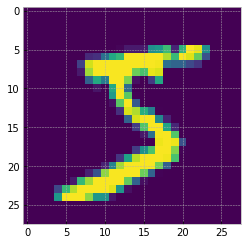

In [25]:
plt.imshow(trainX[0])
plt.show()

49


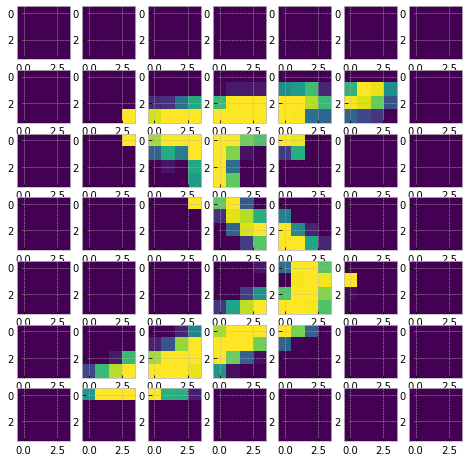

In [26]:
img_list = ImageUtils.split_image(trainX[0],4)
print(len(img_list))
fig = plt.figure(figsize=(8,8))
columns = rows= int(np.sqrt(len(img_list)))

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
plt.show()

64


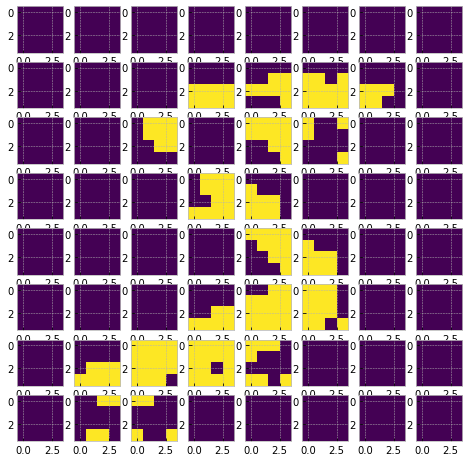

In [27]:
merged_img = qProcessor.quantumEdgeDetect(trainX[0],qProcessor)
img_list = ImageUtils.split_image(merged_img,4)
print(len(img_list))
fig = plt.figure(figsize=(8,8))
columns = rows= int(np.sqrt(len(img_list)))

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
plt.show()

### Pauli Error Noise Model

In [149]:
from qiskit.providers.aer.noise import pauli_error

In [171]:
#@title QuantumProcessor code:- simulator circuit todo: real quantum machine
class QuantumProcessor(object):
  def __init__(self,image_crop_size):
    # Initialize some global variable for number of qubits
    self.image_crop_size = image_crop_size
    self.data_qb = math.ceil(math.log2(image_crop_size**2))
    anc_qb = 1
    self.total_qb = self.data_qb + anc_qb
    print('total qbits ' ,self.total_qb)
    # Initialize the amplitude permutation unitary
    self.D2n_1 = np.roll(np.identity(2**self.total_qb), 1, axis=1)

  # Convert the raw pixel values to probability amplitudes
  def amplitude_encode(self,img_data):
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    image_norm = []
    for arr in img_data:
      for ele in arr:
        image_norm.append(ele / rms)      
    return np.array(image_norm)


  def get_noise_model(self):
    noise_model = NoiseModel()
    # Error probabilities
    p_error = 0.001

    bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
    phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
    bitphase_flip = bit_flip.compose(phase_flip)
    
    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(bitphase_flip, ['u1', 'u2', 'u3', 'h', 'id', 'rz', 'sx', 'rx', 'ry'])
    #noise_model.add_all_qubit_quantum_error(phase_flip, ['u1', 'u2', 'u3', 'h', 'id', 'rz', 'sx', 'rx', 'ry'])
    #noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    
    return noise_model

  # runing the ciruit on simulator
  def runOnSimulator(self,back, circuit, qc_h, qc_v):
    noise_model = self.get_noise_model()
    results = execute(circuit, backend=back, noise_model=noise_model).result()
    sv_h = results.get_statevector(qc_h)
    sv_v = results.get_statevector(qc_v)
    return sv_h,sv_v

  def getImgCropSize(self):
    return self.image_crop_size

  # input: 1D splited images, output: edge detected 1D splitted images
  def simulatorCircuit(self,image_splits,verbose=False):
    threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)
    back = Aer.get_backend('statevector_simulator')
    qc_h = QuantumCircuit(self.total_qb)
    qc_v = QuantumCircuit(self.total_qb)

    edges = []
    tot_time = time.time()
    for i in range(len(image_splits)):
        start_time = time.time() 
        img = image_splits[i]
        if img.sum() == 0:
          edges.append(img.astype(int))
          continue

        #encoding
        image_norm_h = self.amplitude_encode(img)
        if verbose:
          print("h", image_norm_h.sum())
        image_norm_v = self.amplitude_encode(img.T)
        if verbose:
          print("v", image_norm_v.sum())
      
        # horizontal
        qc_h.initialize(image_norm_h, range(1, self.total_qb))
        qc_h.h(0)
        qc_h.unitary(self.D2n_1, range(self.total_qb))
        qc_h.h(0)
        
        # vertical    
        qc_v.initialize(image_norm_v, range(1, self.total_qb))
        qc_v.h(0)
        qc_v.unitary(self.D2n_1, range(self.total_qb))
        qc_v.h(0)

        circ_list = [qc_h, qc_v]
        
        #running the ciruit 
        sv_h, sv_v = self.runOnSimulator(back, circ_list, qc_h, qc_v)

        edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**self.data_qb)])).reshape(self.image_crop_size, self.image_crop_size)
        edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**self.data_qb)])).reshape(self.image_crop_size, self.image_crop_size).T
        edge_scan_sim = edge_scan_h | edge_scan_v
        if verbose:
          plt.imshow(edge_scan_sim)
          plt.show()
          print(edge_scan_sim.shape)
        edges.append(edge_scan_sim)
        if verbose:
          print(i,":->",time.time() - start_time)
        # plot_image(edge_scan_sim, 'Edge Detected image')
    if verbose:
      print('total time',time.time() -  tot_time)
    return edges

  def quantumEdgeDetect(self,img,qProcessor,verbose = False):
    if verbose:
      plt.imshow(img)
      plt.show()
    img = ImageUtils.preProcess(img,verbose)
    if verbose:
      plt.imshow(img)
      plt.show()
    img_grid = ImageUtils.split_image(img,qProcessor.getImgCropSize())

    edges = qProcessor.simulatorCircuit(img_grid,verbose)
    merged_img = ImageUtils.mergeAndDisplay(edges,img.shape[0]/qProcessor.getImgCropSize(),verbose)
    
    return merged_img


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


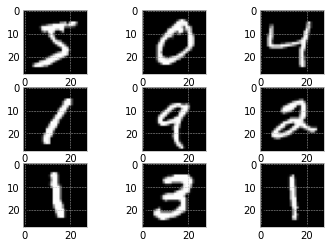

In [172]:
#load dataset
from tensorflow.keras.datasets import mnist
(trainX, trainy), (testX, testy) = mnist.load_data()
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
plt.show()

In [173]:
#config
image_crop_size =4
qProcessor = QuantumProcessor(image_crop_size)

#testing on 1 image
merged_img = qProcessor.quantumEdgeDetect(trainX[23],qProcessor)

total qbits  5


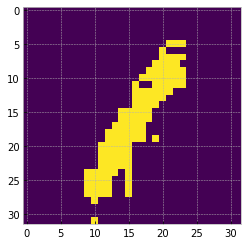

In [174]:
plt.imshow(merged_img)
plt.show()

In [175]:
### Test data from Noiseless Model
# testNsample = 50
# newTestX = np.zeros((testNsample, 32*32))
# for i in range(testNsample):
#   newTestX[i] = qProcessor.quantumEdgeDetect(testX[i],qProcessor).flatten()
#   if i%10==0:
#     print('status :',i,'/',testNsample)

In [ ]:
# 32 x 32 because MNIST is resized to 32 pixels
start_time = time.time()
trainNsample = 50
newTrainX = np.zeros((trainNsample, 32*32))
for i in range(trainNsample):
  newTrainX[i] = qProcessor.quantumEdgeDetect(trainX[i],qProcessor).flatten()
  if i%10==0:
    print('status :',i,'/',trainNsample)
# testNsample = 50
# newTestX = np.zeros((testNsample, 32*32))
# for i in range(testNsample):
#   newTestX[i] = qProcessor.quantumEdgeDetect(testX[i],qProcessor).flatten()
#   if i%10==0:
#     print('status :',i,'/',testNsample)
print("Time taken: ", time.time() - start_time)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf2 = LogisticRegression(fit_intercept=True,
                        multi_class='auto',
                        penalty='l1', #lasso regression
                        solver='saga',
                        max_iter=1000,
                        C=50,
                        verbose=2, # output progress
                        n_jobs=5, # parallelize over 5 processes
                        tol=0.01
                         )

clf2 = clf2.fit(newTrainX, trainy[:trainNsample])

In [ ]:
clf2 = clf2.fit(newTrainX, trainy[:trainNsample])
print("Accuracy on test dataset = %3.2f" %(clf2.score(newTestX, testy[:testNsample])))

In [ ]:
## Bit Flip
# Noise 0: 0.78
# Noise 0.001: 0.68
# Noise 0.01: 0.70

## Phase Flip
# Noise 0: 0.78
# Noise 0.001: 
# Noise 0.01: 

# Combined
# Noise 0:
# Noise 0.001: 
# Noise 0.01: 


